In [1]:
import random
import re

import pandas as pd
import pytorch_lightning as pl

from sklearn.metrics import roc_auc_score

import seaborn as sns
import matplotlib.pyplot as plt

from freestyl.dataset.dataframe_wrapper import DataframeWrapper
from freestyl.supervised.siamese import train_dataframewrappers, get_df_prediction
from freestyl.supervised.siamese.utils import score_from_preds, find_index_of_first_change
from freestyl.utils import plot_aucroc_curve
#>>> x = [1, 2, 3, 4, 5, 6]
#>>> .shuffle(x)

NEW_DATASET = False
SPLIT_ON_AUTHORS = False
USE_POS = True
USE_TRIG = True
USE_FW = True
LR = 1e-4
BATCH = 64
DROPOUT = .3
LOSS = "stn_contrastive"
CHRYSOSTOM = False
SAMPLE = True
DYDIMUS = True
COMMENT = False
DEV_MINER = True
SPLIT = False
ISDIST = "linear" not in LOSS
METRICKEY = "Probability" if not ISDIST else "Distance"

if SPLIT:
    SIZE = (32, 32, 32)
elif USE_POS and not USE_FW:
    SIZE = 50
elif USE_POS and USE_FW:
    SIZE = 64
else:
    SIZE = 64
    
seed = 42
IGNORE_KEYS = [
    "file", "author", "textgroup", "title", "tokens", "length", "modified_text"
]
REMOVED = ["Euclides"]


def make_file_name(filename: str) -> str:
    *x, y = filename.split(".")
    x = ".".join(x)
    *dirs, x = x.split("/")
    dirs = "/".join(dirs)
    print()
    name = f"TRI[{USE_TRIG}]B[{BATCH}]Do[{DROPOUT}]Min[{DEV_MINER}]Split[{SPLIT}]Pos[{USE_POS}]FW[{USE_FW}]LR[{LR}]SIZE[{SIZE}]LOSS[{LOSS}]CHRYS[{CHRYSOSTOM}]DYD[{DYDIMUS}]SAMPLE[{SAMPLE}]COMMENT[{COMMENT}].{x}.{y}"
    if dirs:
        return f"{dirs}/{name}"
    return name
    

/home/thibault/dev/chrysostylom/env/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/thibault/dev/chrysostylom/env/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c104cuda20CUDACachingAllocator12recordStreamERKNS_7DataPtrENS0_10CUDAStreamE
  warn(f"Failed to load image Python extension: {e}")
/home/thibault/dev/chrysostylom/env/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/home/thibault/dev/chrysostylom/env/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in 

## Import Data

In [2]:
def get_train_dev_test(filtre, seed=42, ratio=10):
    test = len(filtre) * ratio // 100
    dev_and_test = test * 2
    print(f"Train categorical samples: {len(filtre)-dev_and_test}")
    print(f"Dev   categorical samples: {dev_and_test-test}")
    print(f"Test  categorical samples: {test}")
    r = random.Random(seed)
    r.shuffle(filtre)
    return filtre[:-dev_and_test], filtre[-dev_and_test:-test], filtre[-test:]


if NEW_DATASET:
    df = pd.read_csv("tlg-features.csv").sample(frac=1)
    #df = df[df.tokens >= 5000]
    #print(">= 5000", df.shape)
    #df = df[~df.file.isin(POETRY)]
    #print(">= Poetry", df.shape)
    # df = df[~df.title.str.contains("Dub\.|Sp\.|Fragm|Excerpt|(e cod\.)|Suda|recensio|fragm|sp\.|dub\.|(fort\. auctore)|Scholia")]
    print("Title filter", df.shape)
    #df = df[~df["full-pos-text"].isna()]
    #print(">= POS missing", df.shape)
    
    # Filter based on authors, to generalize better. Everything should be out of domain\
    train, dev, test = [], [], []
    if SPLIT_ON_AUTHORS:
        authors = df.author.value_counts()
        a, b, c = get_train_dev_test(authors[authors > 1].index.tolist())
    else:
        a, b, c = get_train_dev_test(df.title.unique().tolist())
        
    train.extend(a)
    dev.extend(b)
    test.extend(c)
    
#     a, b, c = get_train_dev_test(authors[authors == 1].index.tolist())
#     train.extend(a)
#     dev.extend(b)
#     test.extend(c)

    if SPLIT_ON_AUTHORS:
        train = df[df.author.isin(train)].copy(deep=True)
        dev = df[df.author.isin(dev)].copy(deep=True)#.author.value_counts()
        test = df[df.author.isin(test)].copy(deep=True)#.author.value_counts()
    else:
        train = df[df.title.isin(train)].copy(deep=True)
        dev = df[df.title.isin(dev)].copy(deep=True)#.author.value_counts()
        test = df[df.title.isin(test)].copy(deep=True)#.author.value_counts()
        
    train.to_csv("tlg-train.csv", index=False)
    dev.to_csv("tlg-dev.csv", index=False)
    test.to_csv("tlg-test.csv", index=False)
else:
    train = pd.read_csv("tlg-train.csv")
    dev = pd.read_csv("tlg-dev.csv")
    test = pd.read_csv("tlg-test.csv")
    
train = train[~train.author.isin(REMOVED)]
dev = dev[~dev.author.isin(REMOVED)]
test = test[~test.author.isin(REMOVED)]

if not CHRYSOSTOM:
    train = train[~train.author.str.contains("Chrysosto")]
    dev = dev[~dev.author.str.contains("Chrysosto")]
    test = test[~test.author.str.contains("Chrysosto")]
    
if not DYDIMUS:
    train = train[~train.author.str.contains("Didym")]
    dev = dev[~dev.author.str.contains("Didym")]
    test = test[~test.author.str.contains("Didym")]
    
if not COMMENT:
    train = train[~train.title.str.contains("Comment")]
    dev = dev[~dev.title.str.contains("Comment")]
    test = test[~test.title.str.contains("Comment")]

print(f"Train Shape : {train.shape}")
print(f"Dev Shape : {dev.shape}")
print(f"Test Shape : {test.shape}")

Train Shape : (1266, 2108)
Dev Shape : (141, 2108)
Test Shape : (158, 2107)


In [3]:
train.title.str.contains("Comment").value_counts()
test.title.str.contains("Comment").value_counts()

False    158
Name: title, dtype: int64

In [4]:
train.title.unique().shape

(383,)

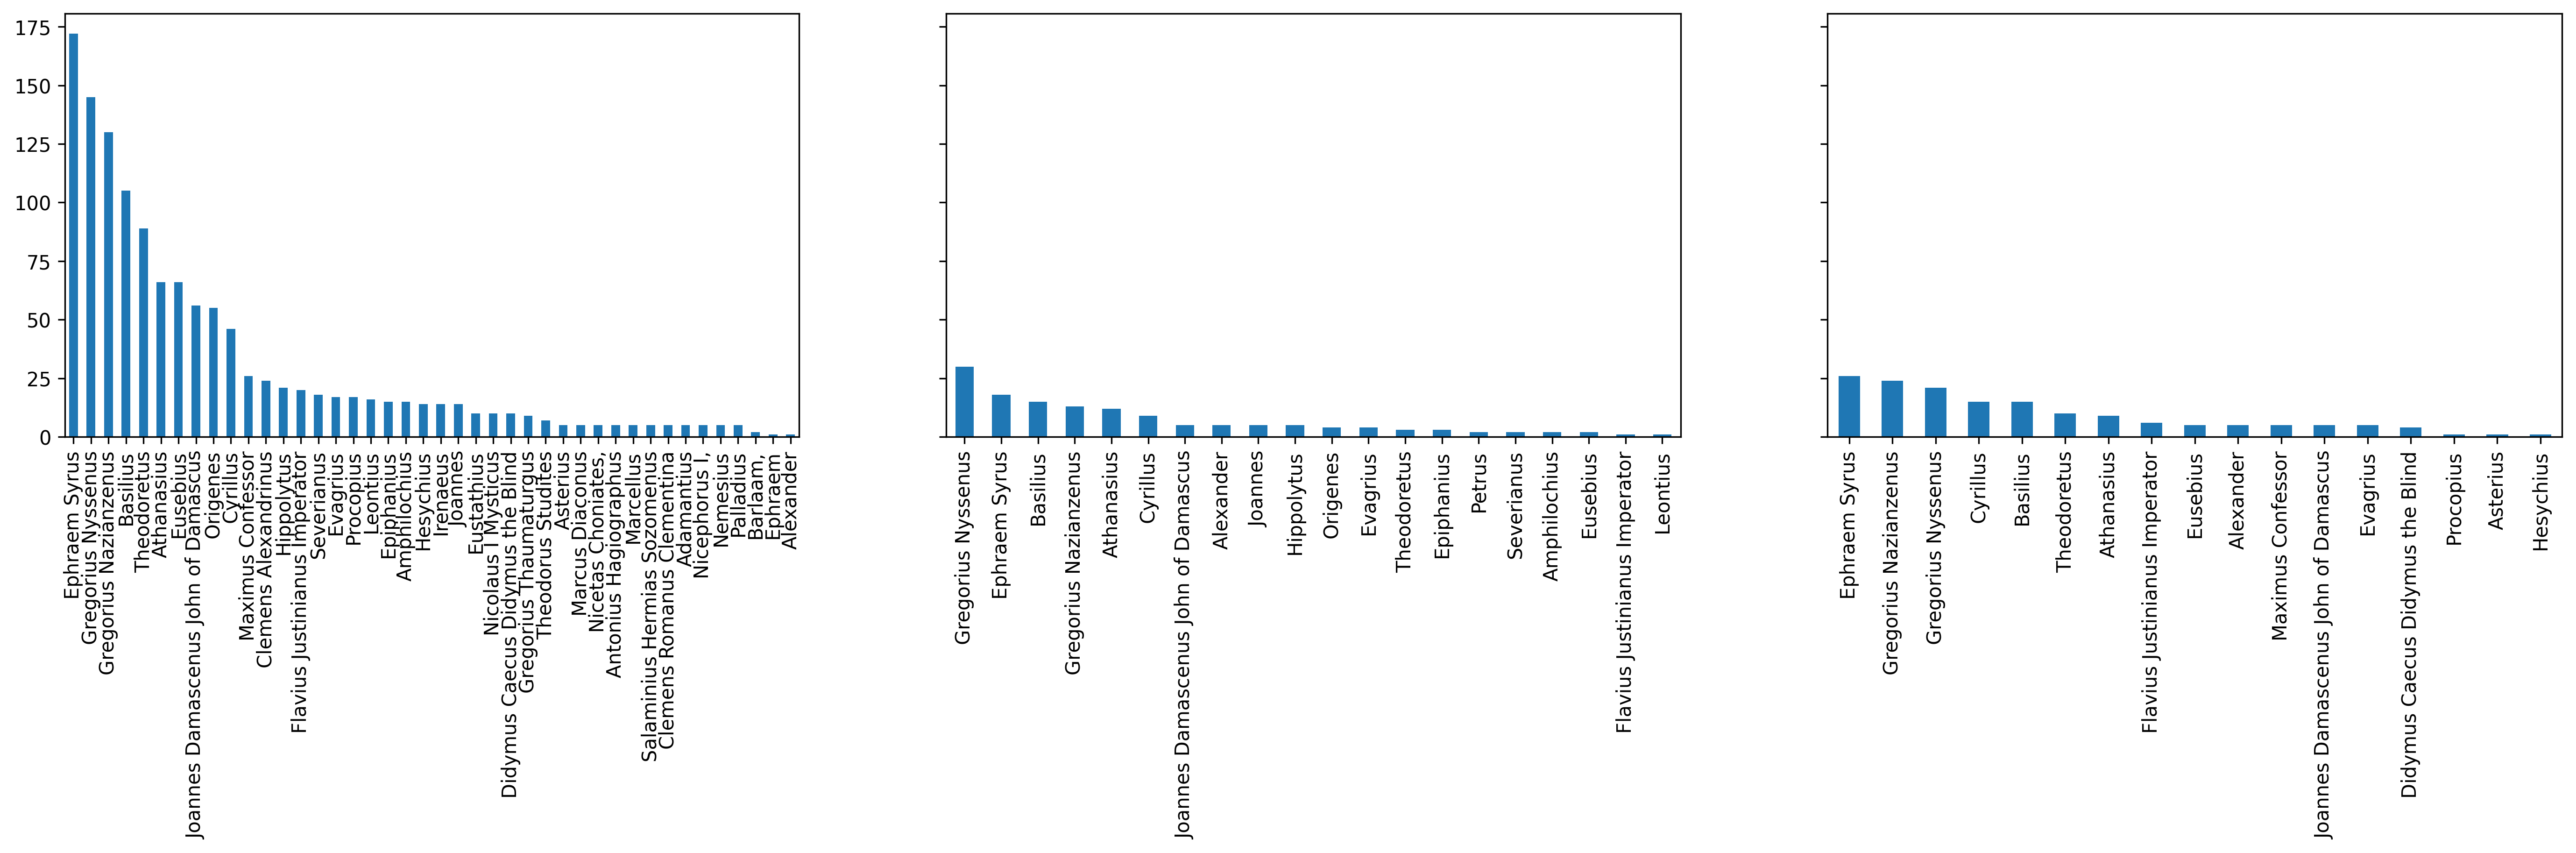

In [5]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, dpi=300, figsize = (23, 4), sharey=True)
train.author.value_counts().plot.bar(ax=ax1)
dev.author.value_counts().plot.bar(ax=ax2)
test.author.value_counts().plot.bar(ax=ax3)
fig.savefig(make_file_name("samples.png"))

## Util functions

In [6]:
def assign_normalization(dfw):
    dfw.normalized._dataframe = dfw.dataframe.fillna(0)
    
def get_scores(scores, distance: float, col=METRICKEY, noprint=False) -> None:

    if "distance" in col.lower():
        scores["Attribution"] = scores[col] <= distance
    else:
        scores["Attribution"] = scores[col] >= distance
    
    pos = scores[scores.IsAPair].Attribution.value_counts().to_dict()
    negs = scores[~scores.IsAPair].Attribution.value_counts().to_dict()
    
    tp = pos.get(True, 0)
    fn = pos.get(False, 0)
    fp = negs.get(True, 0)
    tn = negs.get(False, 0)
    
    if noprint is False:
        print(f"True positives: {tp}\nFalse Negative {fn}")
        print(f"True Negative {tn}")
        print(f"False positives: {fp}\nAccuracy: {tp/(fn+tp):.2f}")
    return tp, fp, tn, fn

## Automatically retrieve some constant parameters

In [7]:
POS_COLS = [
    col
    for col in train.columns
    if col.startswith("$POS$")
]
FW_COLS = [
    col
    for col in train.columns
    if col.startswith("$MFW$")
]
TRIG_COLS = [
    col
    for col in train.columns
    if col.startswith("$TRI$")
]
IGNORE = set(IGNORE_KEYS + (
    POS_COLS if not USE_POS else []
) + (
    FW_COLS if not USE_FW else []
)
 + (
    TRIG_COLS if not USE_TRIG else []
))

## Get DataFrameWrapper

In [8]:
data = DataframeWrapper(train, target="author", label=["author", "title"], x_ignore=IGNORE)
assign_normalization(data)
data_dev = DataframeWrapper(dev, target="author", label=["author", "title"], x_ignore=IGNORE)
data_dev.update_features(data.features)
assign_normalization(data_dev)
data_test = DataframeWrapper(test, target="author", label=["author", "title"], x_ignore=IGNORE)
data_test.update_features(data.features)
assign_normalization(data_test)
data._x_ignore

2101 new features found, setting them as 0.


('file', 'modified_text', 'author', 'textgroup', 'title', 'length', 'tokens')

## CHecking some details

In [9]:
data.normalized.xs.head()

,Unnamed: 0,$POS$v-n-v,$POS$v-c-d,$POS$d-l-n,$POS$l-n-n,$POS$d-n-v,$POS$n-v-l,$POS$l-l-n,$POS$n-n-v,$POS$n-v-n,...,$TRI$σῶμ,$TRI$οἷο,$TRI$λῳ_,$TRI$_ἤγ,$TRI$ἁπλ,$TRI$_λύ,$TRI$ἐνδ,$TRI$_λυ,$TRI$λεγ,$TRI$εἴρ
0,0,0.001786,0.010714,0.012500,0.017857,0.010714,0.017857,0.008929,0.008929,0.003571,...,0.000268,0.000000,0.000268,0.000000,0.000268,0.000268,0.000268,0.000000,0.000000,0.0
3,3,0.002519,0.005038,0.015113,0.015113,0.002519,0.022670,0.005038,0.002519,0.007557,...,0.000000,0.000279,0.000279,0.000000,0.000279,0.000000,0.000279,0.000000,0.000000,0.0
5,5,0.007018,0.001754,0.010526,0.021053,0.001754,0.024561,0.001754,0.012281,0.001754,...,0.000279,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000558,0.001116,0.0
6,6,0.000000,0.003992,0.007984,0.021956,0.000000,0.017964,0.009980,0.013972,0.003992,...,0.000000,0.000000,0.000000,0.000278,0.000000,0.000000,0.000000,0.000000,0.000555,0.0
7,7,0.005894,0.015717,0.013752,0.011788,0.005894,0.009823,0.007859,0.011788,0.005894,...,0.000000,0.000275,0.000000,0.000000,0.000000,0.000000,0.000275,0.000275,0.000824,0.0


## Training

In [10]:
models, train_trainer = train_dataframewrappers(
    train=data,
    dev=data_dev,
    test=data_test,
    optim="Adam",
    accelerator="gpu",
    # 2e-5, Batch 32
    learning_rate=LR,
    margin=1,
    dimension=SIZE,
    loss=LOSS,
    pos_strategy="easy",
    neg_strategy="semihard",
    sample=SAMPLE,
    batch_size=BATCH,
    gpus=1,
    dropout=DROPOUT,
    min_epochs=100,
    miner_for_dev=DEV_MINER,
    split_dim=find_index_of_first_change(data.features) if SPLIT else None,
    patience=20
    #loss="triplet"
)


/home/thibault/dev/chrysostylom/env/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/thibault/dev/chrysostylom/env/lib/python3.10/site-packages/pytorch_lightning/loops/utilities.py:89: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                              | Params
----------------------------------------------------------------
0 | aucroc    | AUROC                             | 0     
1 | distance  | SNRDistance                       | 0     
2 | loss_func | SignalToNoiseRatioContr

Sanity Checking: 0it [00:00, ?it/s]

/home/thibault/dev/chrysostylom/env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/thibault/dev/chrysostylom/env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/thibault/dev/chrysostylom/env/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1892: PossibleUserWarning: The number of training batches (20) is sm

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but the required `min_epochs=100` or `min_steps=None` has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but the required `min_epochs=100` or `min_steps=None` has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but the required `min_epochs=100` or `min_steps=None` has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but the required `min_epochs=100` or `min_steps=None` has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but the required `min_epochs=100` or `min_steps=None` has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but the required `min_epochs=100` or `min_steps=None` has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but the required `min_epochs=100` or `min_steps=None` has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but the required `min_epochs=100` or `min_steps=None` has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but the required `min_epochs=100` or `min_steps=None` has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but the required `min_epochs=100` or `min_steps=None` has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but the required `min_epochs=100` or `min_steps=None` has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but the required `min_epochs=100` or `min_steps=None` has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but the required `min_epochs=100` or `min_steps=None` has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but the required `min_epochs=100` or `min_steps=None` has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but the required `min_epochs=100` or `min_steps=None` has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but the required `min_epochs=100` or `min_steps=None` has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but the required `min_epochs=100` or `min_steps=None` has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but the required `min_epochs=100` or `min_steps=None` has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but the required `min_epochs=100` or `min_steps=None` has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but the required `min_epochs=100` or `min_steps=None` has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but the required `min_epochs=100` or `min_steps=None` has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but the required `min_epochs=100` or `min_steps=None` has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but the required `min_epochs=100` or `min_steps=None` has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but the required `min_epochs=100` or `min_steps=None` has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but the required `min_epochs=100` or `min_steps=None` has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but the required `min_epochs=100` or `min_steps=None` has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but the required `min_epochs=100` or `min_steps=None` has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but the required `min_epochs=100` or `min_steps=None` has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but the required `min_epochs=100` or `min_steps=None` has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but the required `min_epochs=100` or `min_steps=None` has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but the required `min_epochs=100` or `min_steps=None` has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but the required `min_epochs=100` or `min_steps=None` has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but the required `min_epochs=100` or `min_steps=None` has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but the required `min_epochs=100` or `min_steps=None` has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but the required `min_epochs=100` or `min_steps=None` has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but the required `min_epochs=100` or `min_steps=None` has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but the required `min_epochs=100` or `min_steps=None` has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but the required `min_epochs=100` or `min_steps=None` has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Trainer was signaled to stop but the required `min_epochs=100` or `min_steps=None` has not been met. Training will continue...


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/thibault/dev/chrysostylom/env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_auroc           0.8257251381874084
        test_loss           1.0309821367263794
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [11]:
models.eval()

SiameseFeatureModule(
  (aucroc): AUROC()
  (distance): SNRDistance()
  (loss_func): SignalToNoiseRatioContrastiveLoss(
    (distance): SNRDistance()
    (reducer): MultipleReducers(
      (reducers): ModuleDict(
        (pos_loss): AvgNonZeroReducer()
        (neg_loss): AvgNonZeroReducer()
      )
      (default_reducer): MeanReducer()
    )
  )
  (miner): BatchEasyHardMiner(
    (distance): SNRDistance()
  )
  (encoder): Sequential(
    (0): BatchNorm1d(2101, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=2101, out_features=64, bias=True)
  )
)

In [12]:
#pd.DataFrame({key:val for key, val in train_trainer.logger.history.items() if len(val) > 1})

### Get first FP distance

In [13]:
trainer = pl.Trainer(
    gpus=1,
    accelerator="gpu"
)
scores = get_df_prediction(trainer, model=models, compared=data)
#scores
print(f"ROC: {roc_auc_score(scores.IsAPair, scores.Probability)}")

/home/thibault/dev/chrysostylom/env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/thibault/dev/chrysostylom/env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

ROC: 0.9336736673802601


In [14]:
scores[~scores.IsAPair].sort_values("Distance").head()

,ComparedClass,ComparedLabel,ComparatorClass,ComparatorLabel,Distance,Probability,Attribution,IsAPair,K
20973,Origenes,Origenes - Homiliae in Ezechielem,Theodoretus,Theodoretus - Historia ecclesiastica,0.344668,0.655332,True,False,0
20993,Origenes,Origenes - Homiliae in Ezechielem,Theodoretus,Theodoretus - Historia ecclesiastica,0.365940,0.634060,True,False,0
730588,Theodoretus,Theodoretus - Historia ecclesiastica,Origenes,Origenes - Homiliae in Lucam,0.474597,0.525403,True,False,0
20889,Origenes,Origenes - Homiliae in Ezechielem,Theodoretus,Theodoretus - Historia ecclesiastica,0.482320,0.517680,True,False,0
179294,Origenes,Origenes - Homiliae in Leviticum,Theodoretus,Theodoretus - Historia ecclesiastica,0.530613,0.469387,False,False,0


## Evaluating Dev for Test Threshold

In [15]:
trainer = pl.Trainer(
    gpus=1,
    accelerator="gpu"
)
dev_pairs = get_df_prediction(trainer, model=models, compared=data_dev)
#scores
print(f"ROC: {roc_auc_score(dev_pairs.IsAPair, dev_pairs.Probability)}")

/home/thibault/dev/chrysostylom/env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/thibault/dev/chrysostylom/env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

ROC: 0.8261778920246942


In [16]:
dev_pairs[~dev_pairs.IsAPair].sort_values("Distance").head()

,ComparedClass,ComparedLabel,ComparatorClass,ComparatorLabel,Distance,Probability,Attribution,IsAPair,K
6960,Gregorius Nyssenus,Gregorius Nyssenus - De virginitate,Basilius,Basilius - Homiliae in hexaemeron,0.509342,0.490658,False,False,0
7798,Gregorius Nyssenus,Gregorius Nyssenus - Vita sanctae Macrinae,Basilius,Basilius - De spiritu sancto,0.534588,0.465412,False,False,0
7794,Gregorius Nyssenus,Gregorius Nyssenus - Vita sanctae Macrinae,Basilius,Basilius - Homiliae in hexaemeron,0.550573,0.449427,False,False,0
6482,Gregorius Nyssenus,Gregorius Nyssenus - Oratio catechetica magna,Basilius,Basilius - Homiliae in hexaemeron,0.554854,0.445146,False,False,0
456,Basilius,Basilius - De virginitate,Gregorius Nyssenus,Gregorius Nyssenus - Vita sanctae Macrinae,0.555327,0.444673,False,False,0


<AxesSubplot:>

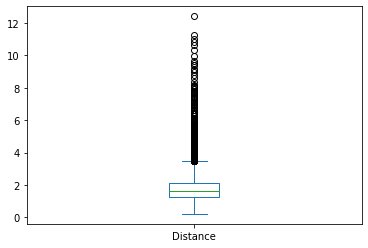

In [17]:
dev_pairs.Distance.plot.box()

In [18]:
#clip = scores.Distance.apply(lambda x: 2 if x > 2 else x)
#scores.Distance = clip

## Study AUCROC

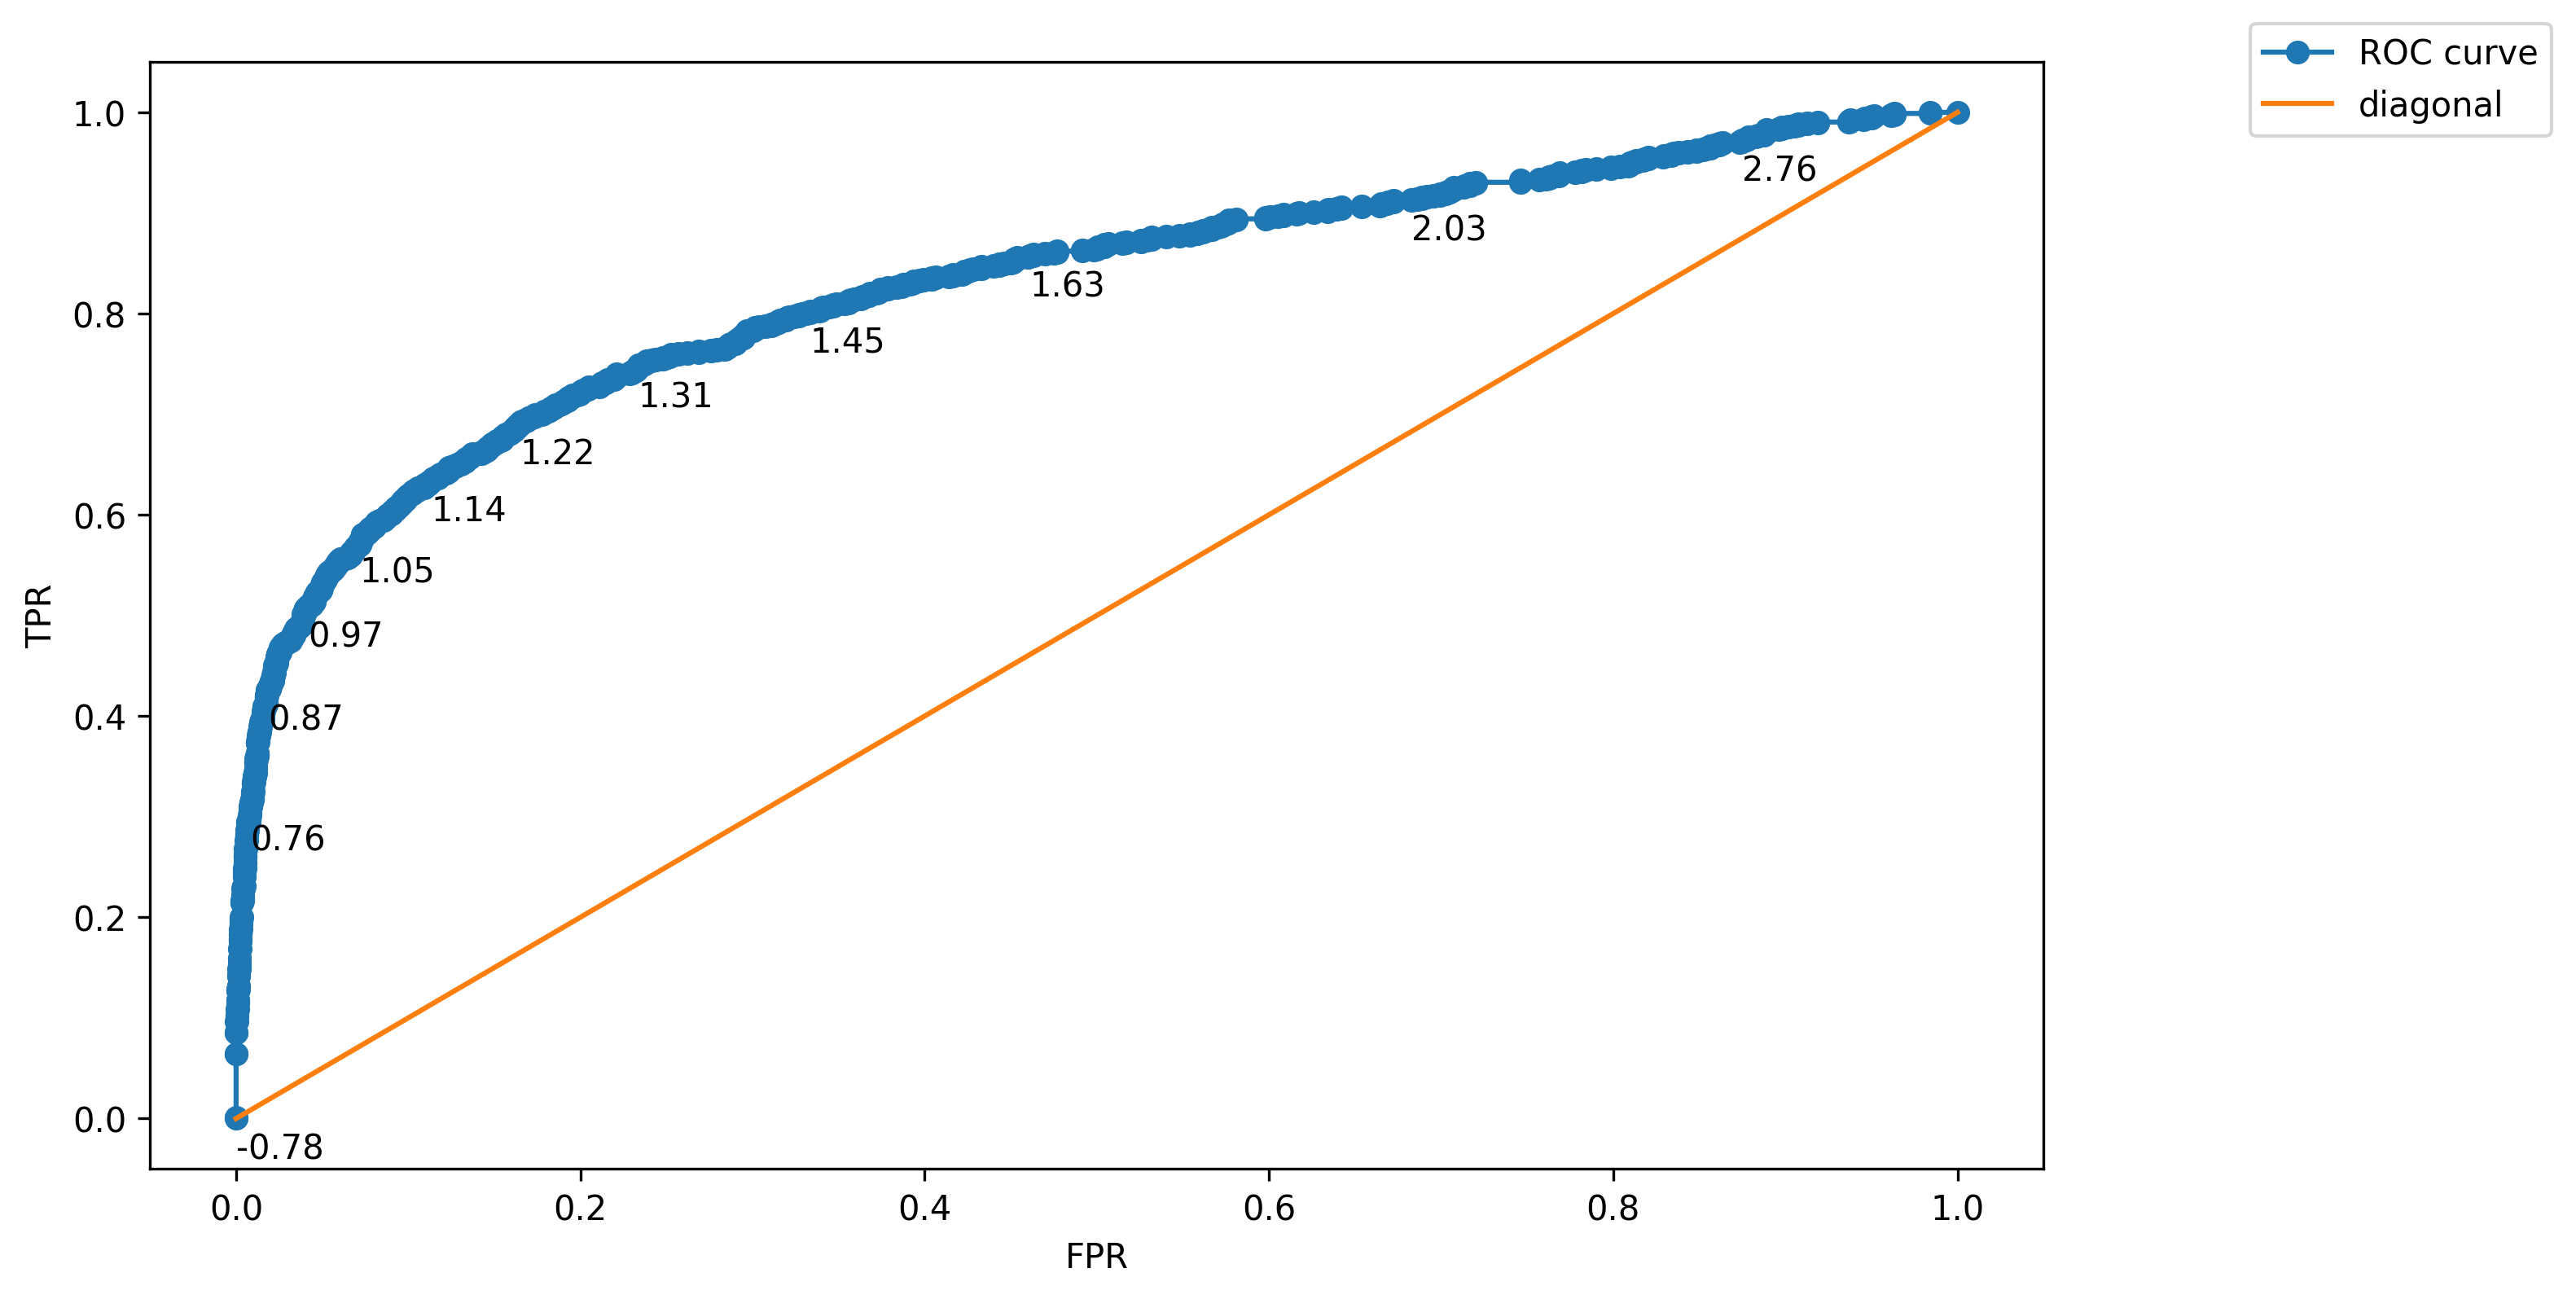

In [19]:
plot_aucroc_curve(dev_pairs.IsAPair, dev_pairs[METRICKEY], nth=100, is_dist=ISDIST)
ax = plt.gca()
ax.legend(bbox_to_anchor=(1.1, 1.05))
plt.gcf().savefig(make_file_name("aucroc-dev.png"))

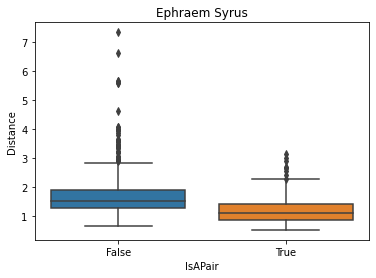

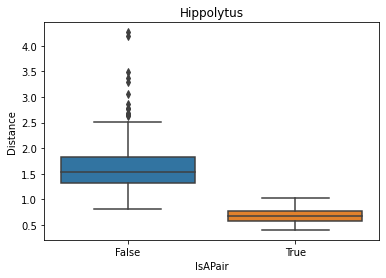

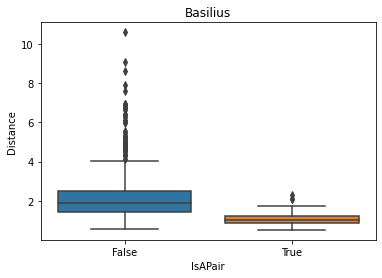

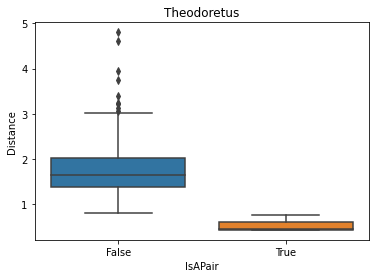

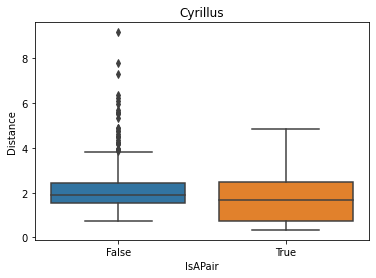

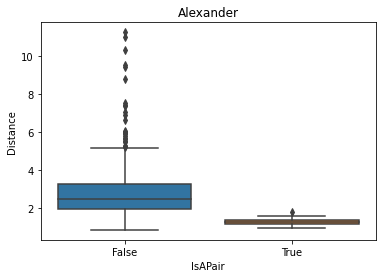

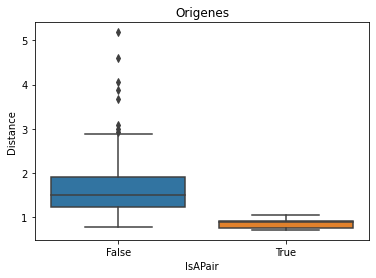

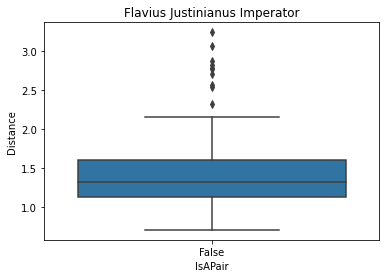

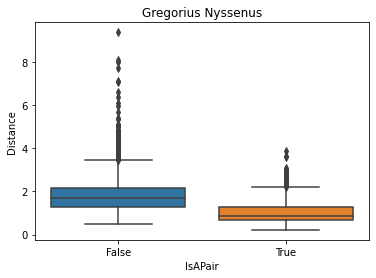

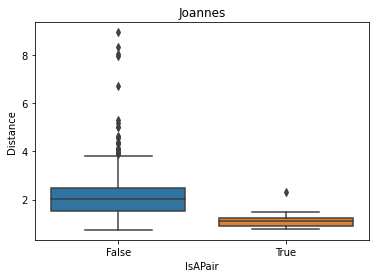

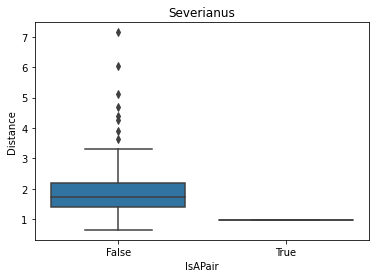

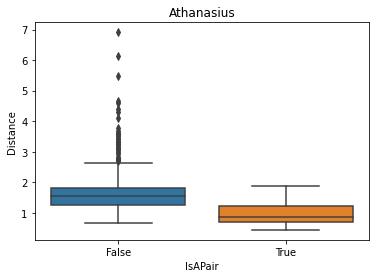

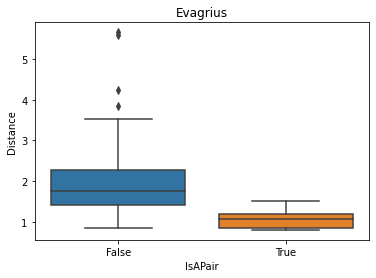

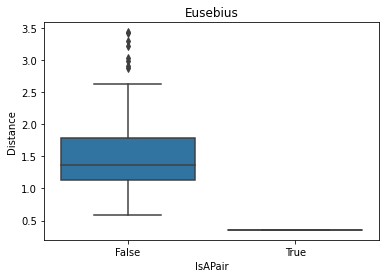

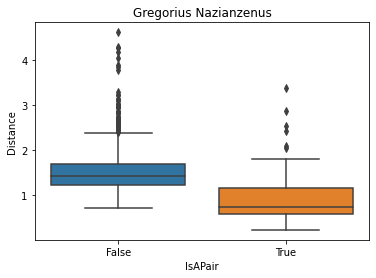

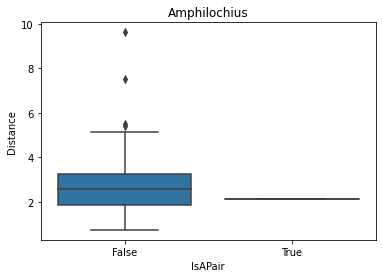

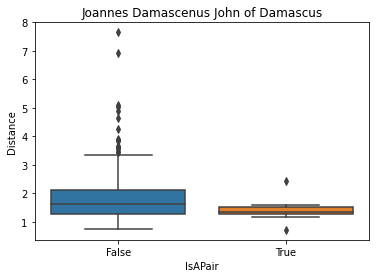

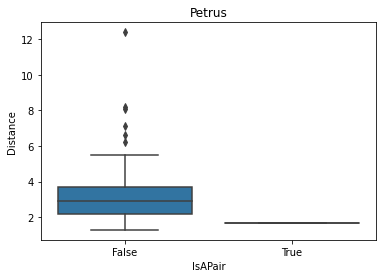

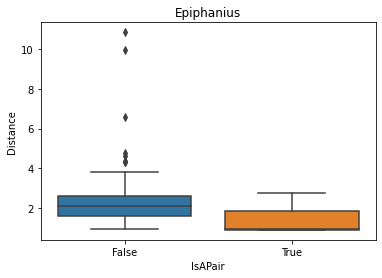

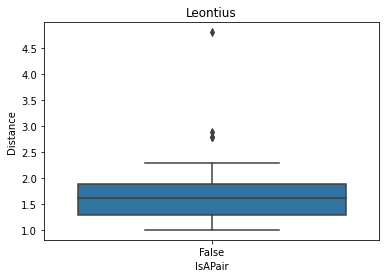

In [20]:
for cls in dev_pairs.ComparedClass.unique():
    plt.figure()
    sns.boxplot(data=dev_pairs[(dev_pairs.ComparedClass==cls)], x="IsAPair", y=METRICKEY)
    plt.gca().set_title(cls)
    plt.gcf().savefig(make_file_name(f"Dev-{cls}.png"))
    #scores.groupby("ComparedClass").plot.box(y="Distance", x="IsAPair")

### Find sweet spot

In [21]:
MAX_DISTANCE = 6
get_scores(dev_pairs, MAX_DISTANCE)
print("\n===\nWithout sampling\n===\n")
get_scores(dev_pairs[(dev_pairs.ComparedLabel != dev_pairs.ComparatorLabel)], MAX_DISTANCE)

True positives: 935
False Negative 0
True Negative 68
False positives: 8867
Accuracy: 1.00

===
Without sampling
===

True positives: 737
False Negative 0
True Negative 68
False positives: 8867
Accuracy: 1.00


/tmp/ipykernel_26071/4096291782.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scores["Attribution"] = scores[col] <= distance


(737, 8867, 68, 0)

## Evaluating Test with Dev Threshold

In [22]:
models.eval()
MAX_DISTANCE = 6

test_pairs = get_df_prediction(trainer, model=models, compared=data_test, threshold=MAX_DISTANCE)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/thibault/dev/chrysostylom/env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

In [78]:
test_pairs[~test_pairs.IsAPair].sort_values(METRICKEY).head()

,ComparedClass,ComparedLabel,ComparatorClass,ComparatorLabel,Distance,Probability,Attribution,IsAPair,K
10257,Flavius Justinianus Imperator,Flavius Justinianus Imperator - Contra monophy...,Athanasius,Athanasius - De synodis Arimini in Italia et S...,0.386301,0.613699,True,False,0
7147,Flavius Justinianus Imperator,Flavius Justinianus Imperator - Contra monophy...,Theodoretus,Theodoretus - Epistulae: Collectio Sirmondiana...,0.588694,0.411306,True,False,0
9166,Gregorius Nazianzenus,Gregorius Nazianzenus - Funebris in laudem Cae...,Basilius,Basilius - De legendis gentilium libris,0.596965,0.403035,True,False,0
8547,Cyrillus,Cyrillus - De adoratione et cultu in spiritu e...,Basilius,Basilius - De legendis gentilium libris,0.600329,0.399671,True,False,0
1806,Gregorius Nyssenus,Gregorius Nyssenus - De mortuis non esse dolendum,Basilius,Basilius - De fide,0.611946,0.388054,True,False,0


In [24]:
print(f"ROC: {roc_auc_score(test_pairs.IsAPair, test_pairs.Probability)}")
MAX_DISTANCE = 6
get_scores(test_pairs, MAX_DISTANCE)
print("\n===\nWithout sampling\n===\n")
get_scores(test_pairs[(test_pairs.ComparedLabel != test_pairs.ComparatorLabel)], MAX_DISTANCE)

ROC: 0.8257250741870172
True positives: 1173
False Negative 0
True Negative 91
False positives: 11139
Accuracy: 1.00

===
Without sampling
===

True positives: 908
False Negative 0
True Negative 91
False positives: 11139
Accuracy: 1.00


/tmp/ipykernel_26071/4096291782.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scores["Attribution"] = scores[col] <= distance


(908, 11139, 91, 0)

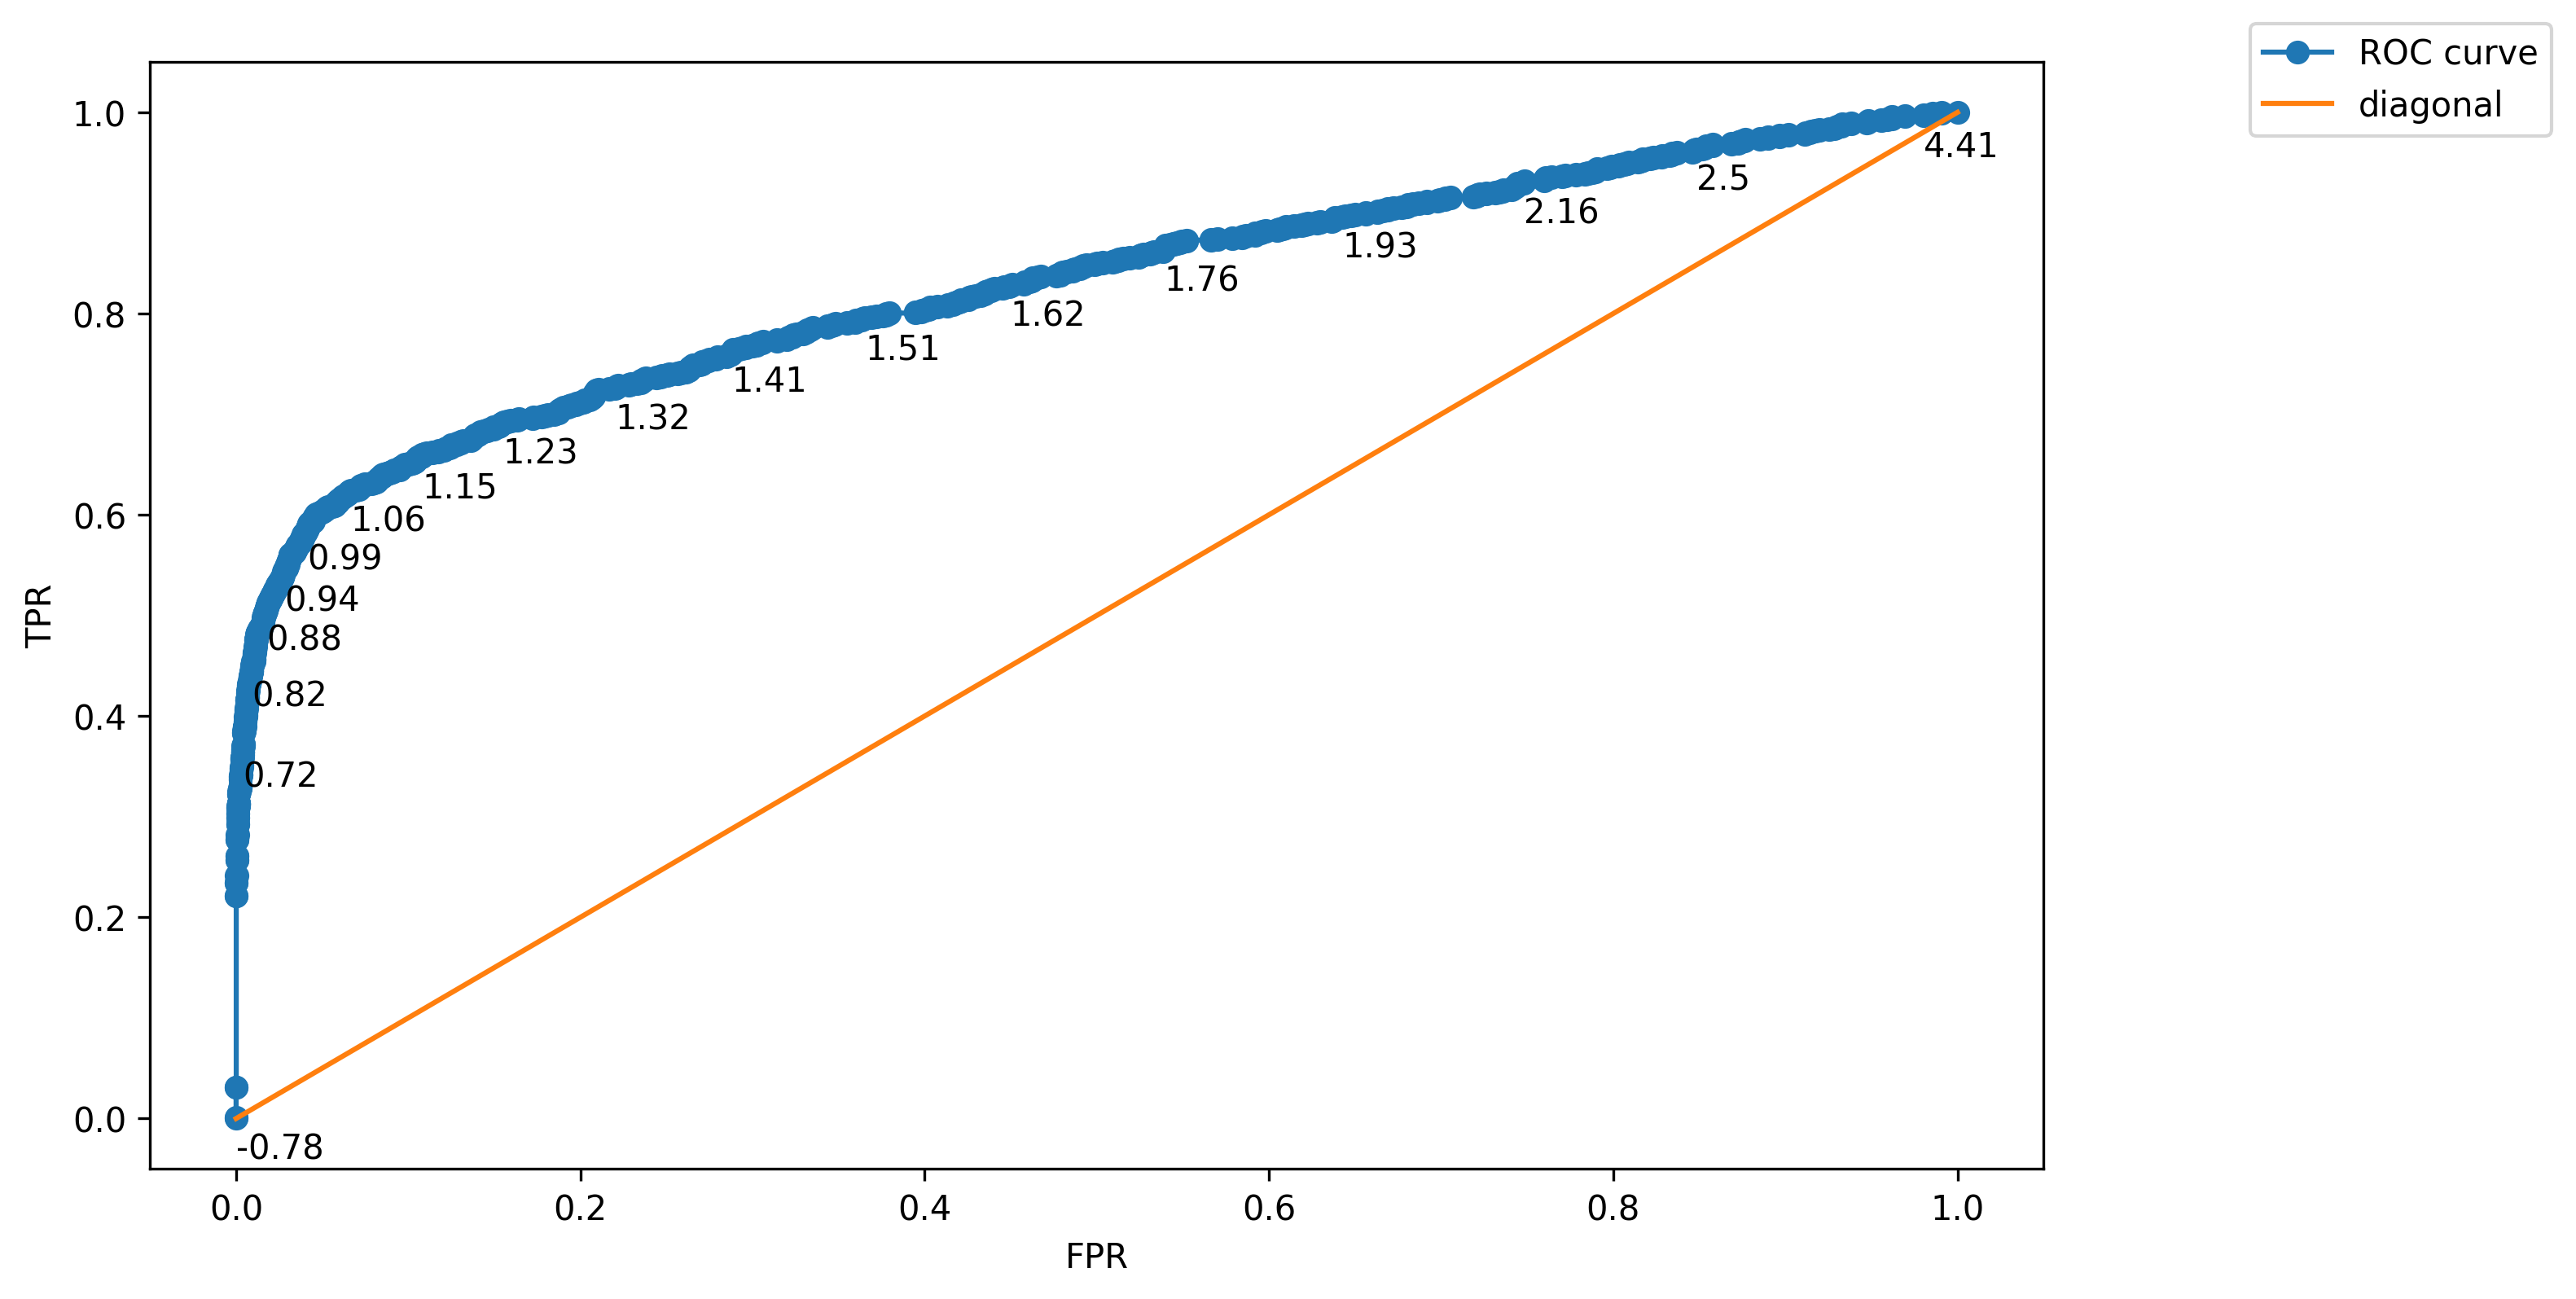

In [25]:
plot_aucroc_curve(test_pairs.IsAPair, test_pairs[METRICKEY], nth=75, is_dist=ISDIST)
ax = plt.gca()
ax.legend(bbox_to_anchor=(1.1, 1.05))
plt.gcf().savefig(make_file_name("test-aucroc.png"))

In [26]:
dev_pairs.to_csv(make_file_name("test-results.csv"))

## On Voicu !

In [62]:
import regex as re
import json
import unicodedata

df = pd.read_csv("pc-features.csv")
DFW = DataframeWrapper(df, label=("author", "title"), target="title", 
                       x_ignore=[col for col in df.columns if col not in data.features])
#
print(len(DFW.features))
print(len(data.features))
DFW.update_features(data.features)
assign_normalization(DFW)
#DFW._features = data.features
print(len(data.features))
print(len(DFW.features))

2059
2101
2101 new features found, setting them as 0.
2101
2101


In [79]:
models.eval()
pairs = get_df_prediction(
    trainer, model=models, 
    compared=DFW, comparator=DFW, 
    threshold=MAX_DISTANCE
)
pairs = pairs[pairs.ComparedLabel != pairs.ComparatorLabel]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/thibault/dev/chrysostylom/env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/thibault/dev/chrysostylom/env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [64]:
pairs["ComparedClass"] = pairs.ComparedLabel.apply(lambda x: x.split()[0].strip())
pairs["ComparatorClass"] = pairs.ComparatorLabel.apply(lambda x: x.split()[0].strip())
pairs["IsAPair"] = pairs.ComparedClass == pairs.ComparatorClass
pairs.head()

,ComparedClass,ComparedLabel,ComparatorClass,ComparatorLabel,Distance,Probability,Attribution,IsAPair,K
0,PC20,PC20 - InIlludCredidiPropterQuodLocutusSum,PC13,PC13 - InVenerabilemCrucem,1.675787,-0.675787,True,False,0
1,PC20,PC20 - InIlludCredidiPropterQuodLocutusSum,PCX,PCX - DeJenunioSermo5B,3.716083,-2.716083,True,False,0
2,PC20,PC20 - InIlludCredidiPropterQuodLocutusSum,PC6,PC6 - DePoenintentiaSermo1,1.493611,-0.493611,True,False,0
3,PC20,PC20 - InIlludCredidiPropterQuodLocutusSum,PC16,PC16 - InIlludSiQuaChristoaNovaCreatura,1.566139,-0.566139,True,False,0
4,PC20,PC20 - InIlludCredidiPropterQuodLocutusSum,PC8,PC8 - DePatientiaSermo1,1.395356,-0.395356,True,False,0


In [65]:
pairs[f"Rounded{METRICKEY}"] = pairs[METRICKEY].round(3)
dists = sorted(pairs[f"Rounded{METRICKEY}"].unique())

pairs["TestTPR"] = .0
pairs["TestPre"] = .0
pairs["TestFPR"] = 1.0
pairs["TestFP"] = -1
pairs["TestFN"] = -1
pairs["TestTP"] = -1
pairs["TestTN"] = -1
pairs["DevTPR"] = .0
pairs["DevPre"] = .0
pairs["DevFPR"] = 1.0
pairs["DevFP"] = -1
pairs["DevFN"] = -1
pairs["DevTP"] = -1
pairs["DevTN"] = -1

for dist in dists:
    tp, fp, tn, fn = get_scores(test_pairs, dist, col=METRICKEY, noprint=True)
    #print(tp, fp, tn, fn)
    filt = pairs[f"Rounded{METRICKEY}"] == dist
    pairs.loc[filt, "TestTPR"] = tp / max([tp+fn, 1])
    pairs.loc[filt, "TestFPR"] = fp / max([fp+tn, 1])
    pairs.loc[filt, "TestPre"] = tp / max([fp+tp, 1])
    pairs.loc[filt, "TestFP"] = fp
    pairs.loc[filt, "TestTP"] = tp
    pairs.loc[filt, "TestFN"] = fn
    pairs.loc[filt, "TestTN"] = tn
    
    # DEV
    
    tp, fp, tn, fn = get_scores(dev_pairs, dist, col=METRICKEY, noprint=True)
    #print(tp, fp, tn, fn)
    filt = pairs[f"Rounded{METRICKEY}"] == dist
    pairs.loc[filt, "DevTPR"] = tp / max([tp+fn, 1])
    pairs.loc[filt, "DevFPR"] = fp / max([fp+tn, 1])
    pairs.loc[filt, "DevPre"] = tp / max([fp+tp, 1])
    pairs.loc[filt, "DevFP"] = fp
    pairs.loc[filt, "DevTP"] = tp
    pairs.loc[filt, "DevFN"] = fn
    pairs.loc[filt, "DevTN"] = tn
    

In [66]:
pairs.sort_values("DevPre").tail()

,ComparedClass,ComparedLabel,ComparatorClass,ComparatorLabel,Distance,Probability,Attribution,IsAPair,K,RoundedDistance,...,TestFN,TestTP,TestTN,DevTPR,DevPre,DevFPR,DevFP,DevFN,DevTP,DevTN
346,PC8,PC8 - DePatientiaSermo1,PC7,PC7 - DeIeiunoSermo3,0.480425,0.519575,True,False,0,0.480,...,1052,121,11229,0.049198,1.0,0.0,0,889,46,8935
308,PC16,PC16 - InIlludSiQuaChristoaNovaCreatura,PC16,PC16 - InIlludSufficitTibiGratiaMea,0.248028,0.751972,True,True,0,0.248,...,1171,2,11230,0.002139,1.0,0.0,0,933,2,8935
1442,PC7,PC7 - DeIeiunoSermo1,PC16,PC16 - InIlludSufficitTibiGratiaMea,0.476446,0.523554,True,False,0,0.476,...,1056,117,11229,0.048128,1.0,0.0,0,890,45,8935
1999,PC16,PC16 - InPsalmum50Homilia2,PC14,PC14 - DeEleemosyna,0.485231,0.514769,True,False,0,0.485,...,1050,123,11229,0.049198,1.0,0.0,0,889,46,8935
756,PC7,PC7 - DeIeiunoSermo2,PC7,PC7 - DeIeiunoSermo5,0.295998,0.704002,True,True,0,0.296,...,1167,6,11230,0.002139,1.0,0.0,0,933,2,8935


In [67]:
pairs.sort_values(["DevPre", "TestPre", "Distance"]).to_csv(make_file_name("pairs-last-experiment.csv"))

## Visualize

In [74]:
from freestyl.supervised.siamese.features.data import make_dataloader
import torch


trainer = pl.Trainer(
    gpus=1,
    accelerator="gpu"
)

# We first get the wonderful classes of compared
dev_vectors, _ = zip(
    *trainer.predict(models, make_dataloader(data_dev, model=models, batch_size=8))
)
dev_vectors = torch.cat([vec.cpu() for vec in dev_vectors], dim=0)
dataframe = []
for label, author, vector in zip(data_dev.get_labels(), data_dev.ys.tolist(), dev_vectors.tolist()):
    dataframe.append((author, label.split(" - ")[1], *vector))

/home/thibault/dev/chrysostylom/env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning:

Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/thibault/dev/chrysostylom/env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

In [75]:
# We first get the wonderful classes of compared
test_vectors, _ = zip(
    *trainer.predict(models, make_dataloader(data_test, model=models, batch_size=8))
)
test_vectors = torch.cat([vec.cpu() for vec in test_vectors], dim=0)
dataframe = []
for label, author, vector in zip(data_test.get_labels(), data_test.ys.tolist(), test_vectors.tolist()):
    dataframe.append((author, label.split(" - ")[1], *vector))

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/thibault/dev/chrysostylom/env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

In [47]:
# We first get the wonderful classes of compared
# pcs, _ = zip(
#     *trainer.predict(models, make_dataloader(DFW, model=models, batch_size=8))
# )
# pcs = torch.cat([vec.cpu() for vec in pcs], dim=0)


# for label, vector in zip(DFW.get_labels(), pcs.tolist()):
#     author, label = label.split(" - ")
#     dataframe.append((author, label, *vector))

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/thibault/dev/chrysostylom/env/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 0it [00:00, ?it/s]

In [76]:
df = pd.DataFrame(dataframe, columns=["Author", "Title", *[f"Dim{i}" for i in range(len(vector))]])
df

,Author,Title,Dim0,Dim1,Dim2,Dim3,Dim4,Dim5,Dim6,Dim7,...,Dim54,Dim55,Dim56,Dim57,Dim58,Dim59,Dim60,Dim61,Dim62,Dim63
0,Gregorius Nyssenus,De professione Christiana ad Harmonium,-0.297226,0.348751,0.128137,-0.644469,0.289885,0.200083,0.050993,0.482332,...,0.484118,0.196600,0.049923,-0.125882,-0.301796,-0.253494,-0.603671,0.265281,-0.160170,0.528205
1,Ephraem Syrus,"Sermo adversus haereticos, in quo tum ex marga...",-0.086822,-0.105766,-0.026526,0.084675,0.079719,0.475698,-0.229504,0.002127,...,0.137823,-0.221865,-0.061625,0.165594,-0.190369,-0.225703,-0.128956,-0.264220,0.095192,0.145242
2,Ephraem Syrus,"Sermo adversus haereticos, in quo tum ex marga...",-0.048385,-0.328793,-0.096078,0.193026,0.286371,0.260794,-0.421424,-0.217198,...,-0.203307,-0.526324,-0.144575,0.178039,0.089954,-0.200092,-0.157469,-0.175190,-0.037739,0.102115
3,Gregorius Nazianzenus,Funebris in laudem Caesarii fratris oratio (or...,-0.303372,0.173279,-0.174471,0.065643,0.134834,0.594160,-0.214057,-0.040038,...,0.107728,-0.024226,0.166982,-0.169151,0.066202,-0.137730,0.117147,-0.339112,0.172397,0.541403
4,Cyrillus,Epistulae paschales sive Homiliae paschales (e...,0.082886,0.545323,-0.148142,-0.253751,-0.430112,0.056199,0.509073,0.492861,...,0.679464,-0.099532,0.232343,-0.326338,-0.283830,0.225045,0.016264,0.359860,-0.191933,-0.285842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153,Cyrillus,Epistulae paschales sive Homiliae paschales (e...,0.098220,0.317017,0.047294,-0.337624,0.017318,0.091647,0.235365,0.581444,...,0.581052,0.099773,0.442812,-0.477173,-0.111678,0.158716,-0.124170,0.185983,-0.242711,-0.228574
154,Gregorius Nyssenus,Contra Eunomium,-0.456690,0.508937,0.078090,-0.123005,-0.208037,0.143872,0.072884,-0.057809,...,0.238632,0.173577,0.047883,-0.268124,-0.423376,-0.069158,-0.021309,0.287484,-0.111859,0.562339
155,Theodoretus,Epistulae: Collectio Sirmondiana (epistulae 1-95),0.175488,0.114705,-0.427427,-0.244948,-0.266814,0.279493,0.213699,0.316045,...,-0.223913,-0.092253,0.332182,0.124726,-0.133169,0.087460,0.107413,0.210963,-0.351267,-0.110880
156,Basilius,Homilia in martyrem Julittam,-0.244122,0.423258,-0.288070,0.067860,0.016859,0.230383,-0.076132,-0.048027,...,0.405959,-0.552057,-0.290583,-0.357636,-0.026138,-0.128055,-0.038242,-0.245783,-0.134284,0.287373


In [77]:
from umap import UMAP
import plotly.express as px


umap_2d = UMAP(n_components=2, init='random', random_state=0)

proj_2d = umap_2d.fit_transform(df.loc[:, "Dim0":])

fig_2d = px.scatter(
    proj_2d, x=0, y=1,
    color=df.Author,
    labels={'color': 'Author'},
    hover_name=df.Title,
    #hover_data=["Author", "Title"]
)

fig_2d.show()
fig_2d.write_html(make_file_name("plotly.html"))

In [38]:
df = pd.DataFrame(dataframe, columns=["Author", "Title", *[f"Dim{i}" for i in range(len(vector))]])
df = df[df.Author.str.contains("PC")]
from umap import UMAP
import plotly.express as px


umap_2d = UMAP(n_components=2, init='random', random_state=0)

proj_2d = umap_2d.fit_transform(df.loc[:, "Dim0":])

fig_2d = px.scatter(
    proj_2d, x=0, y=1,
    color=df.Author,
    labels={'color': 'Author'},
    hover_name=df.Title,
    #hover_data=["Author", "Title"]
)

fig_2d.show()
fig_2d.write_html(make_file_name("pc-plotly.html"))